In [316]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

stud_math = pd.read_csv('stud_math.csv')

# изменим названия колонок для удобства
stud_math = stud_math.set_axis(['school', 'sex', 'age', 'address_type', 'family_size',
                                'parents_status', 'mother_education', 'father_education',
                                'mother_job', 'father_job', 'school_reason', 'guardian',
                                'travel_time', 'study_time', 'failures', 'school_support',
                                'family_support', 'paid_math', 'activities', 'nursery',
                                'study_time,granular', 'plans_higher', 'internet_available',
                                'romantic_rel', 'family_rel', 'free_time', 'friend_time',
                                'health', 'absences', 'math_score'], axis=1)

stud_math.head()

,school,sex,age,address_type,family_size,parents_status,mother_education,father_education,mother_job,father_job,school_reason,guardian,travel_time,study_time,failures,school_support,family_support,paid_math,activities,nursery,"study_time,granular",plans_higher,internet_available,romantic_rel,family_rel,free_time,friend_time,health,absences,math_score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


Запишем необходимые функции и иную информацию, которая будет полезна для всего проекта

In [319]:
# Функция для того, чтобы пройтись
# по всем колонкам по типу данных
def function_type(srs):
    if (srs.dtype == 'int64' or srs.dtype == 'float64'):
        display(srs.hist())
        display(srs.nunique())
        display(srs.value_counts() > 10)
        display(srs.describe())
    else:
        display(srs.describe(include='O'))
        display(srs.value_counts())

# Функция показывает все пропущенные значения
# (формула написана не мной, а взята из интернета)


def missing_values_table(df):
    # общее количество пропущенных значений
    mis_val = df.isnull().sum()

    # процент пропущенных значений
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # создание таблицы с полученным результатом
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # переименование колонок
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: 'Missing Values', 1: '% of Total Values'})

    # сортировка значения от большего процента пропусков к меньшему
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

    # общая информация по результатам
    print("В нашей базе данных содержится " + str(df.shape[1]) + " колонок.\n"
          + str(mis_val_table_ren_columns.shape[0]) +
          " колонок с пропущенными значениями.")

    # возвращаем таблицу с результатами
    return mis_val_table_ren_columns

# Функция для изменения данных в столбцах
# с номинативных на числовые


def change_to_number(column):
    return column.apply(LabelEncoder().fit_transform)


# Посмотреть сколько пропусков в строках, если пропусков больше 10,
# то можно убрать такую строку, потому что треть данных отсутствует
# и вряд ли получится их использовать
def check_blanks():
    blanks = []
    for i in range(len(stud_math.iloc[:])):
        y = 0
        for x in range(len(stud_math.iloc[i])):
            if pd.isnull(stud_math.iloc[i][x]):
                y += 1
        blanks.append(y)
    return pd.Series(blanks)

Проверив основную информацию базы данных stud_math, можем сделать следующие выводы:
1. В таблице есть пустые значения  (максимально отсутствуют значения в 45 строках по столбцу 'parents_status')
2. В некоторых столбцах значения числовых переменных выходят за предела условий (например, в столбце "family_rel" по условиям значения от 1 до 5, но мы видим, что минимальное значение по этому столбцу -1)

In [320]:
display(stud_math.describe())
display(stud_math.describe(include='O'))
display(missing_values_table(stud_math))
display(stud_math.info())

,age,mother_education,father_education,travel_time,study_time,failures,"study_time,granular",family_rel,free_time,friend_time,health,absences,math_score
count,395.000000,392.000000,371.000000,367.000000,388.000000,373.000000,388.000000,368.000000,384.000000,387.000000,380.000000,383.000000,389.000000
mean,16.696203,2.750000,2.614555,1.438692,2.038660,0.337802,-6.115979,3.937500,3.231771,3.105943,3.531579,7.279373,52.262211
std,1.276043,1.098127,2.228732,0.694181,0.842078,0.743135,2.526235,0.927277,0.993940,1.115896,1.396019,23.465197,22.919022
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,-12.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,-6.000000,4.000000,3.000000,2.000000,3.000000,0.000000,40.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,-6.000000,4.000000,3.000000,3.000000,4.000000,4.000000,55.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,-3.000000,5.000000,4.000000,4.000000,5.000000,8.000000,70.000000
max,22.000000,4.000000,40.000000,4.000000,4.000000,3.000000,-3.000000,5.000000,5.000000,5.000000,5.000000,385.000000,100.000000


,school,sex,address_type,family_size,parents_status,mother_job,father_job,school_reason,guardian,school_support,family_support,paid_math,activities,nursery,plans_higher,internet_available,romantic_rel
count,395,395,378,368,350,376,359,378,364,386,356,355,381,379,375,361,364
unique,2,2,2,2,2,5,5,4,3,2,2,2,2,2,2,2,2
top,GP,F,U,GT3,T,other,other,course,mother,no,yes,no,yes,yes,yes,yes,no
freq,349,208,295,261,314,133,197,137,250,335,219,200,195,300,356,305,240


В нашей базе данных содержится 30 колонок.
27 колонок с пропущенными значениями.


,Missing Values,% of Total Values
parents_status,45,11.4
paid_math,40,10.1
family_support,39,9.9
father_job,36,9.1
internet_available,34,8.6
romantic_rel,31,7.8
guardian,31,7.8
travel_time,28,7.1
family_rel,27,6.8
family_size,27,6.8


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address_type         378 non-null    object 
 4   family_size          368 non-null    object 
 5   parents_status       350 non-null    object 
 6   mother_education     392 non-null    float64
 7   father_education     371 non-null    float64
 8   mother_job           376 non-null    object 
 9   father_job           359 non-null    object 
 10  school_reason        378 non-null    object 
 11  guardian             364 non-null    object 
 12  travel_time          367 non-null    float64
 13  study_time           388 non-null    float64
 14  failures             373 non-null    float64
 15  school_support       386 non-null    obj

None

## Начнем проверку каждой колонки по отдельности

Посмотрев на количество пропусков, я выяснил, что нет строки с 10 или более пропущенными значениями

In [321]:
stud_math['blanks'] = check_blanks()

stud_math[stud_math['blanks'] >= 10]

,school,sex,age,address_type,family_size,parents_status,mother_education,father_education,mother_job,father_job,school_reason,guardian,travel_time,study_time,failures,school_support,family_support,paid_math,activities,nursery,"study_time,granular",plans_higher,internet_available,romantic_rel,family_rel,free_time,friend_time,health,absences,math_score,blanks


Аббревиатура школы, в которой учится ученик

Нет пропусков, всего 2 уникальных значения

In [322]:
check_school = stud_math.copy()

# сколько учеников в каждой школе участвовали в сборе данных
function_type(check_school.school)
display(check_school.loc[:, ['school']].info())

count     395
unique      2
top        GP
freq      349
Name: school, dtype: object

GP    349
MS     46
Name: school, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   school  395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

Пол ученика ('F' - женский, 'M' - мужской)

Нет пропусков, всего 2 уникальных значения

In [323]:
check_sex = stud_math.copy()

function_type(check_sex.sex)

count     395
unique      2
top         F
freq      208
Name: sex, dtype: object

F    208
M    187
Name: sex, dtype: int64

Возраст учеников (от 15 до 22)

Нет пропусков, 8 уникальных значения

Согласно гистограмме, полученной в ходе проверки возвраста учеников, ученик в возрасте 22-хлет является выбросом, однако от нас требуется выяснить влияние различных факторов на получение баллов по экзамену у всех учеников.

16    104
17     98
15     82
18     82
19     24
20      3
21      1
22      1
Name: age, dtype: int64

25-й перцентиль: 16.0, 75-й перцентиль: 18.0, IQR: 2.0,  Границы выбросов: [13.0, 21.0].


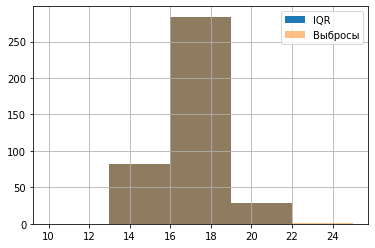

In [281]:
check_age = stud_math.copy()

display(check_age.age.value_counts())

IQR = check_age.age.quantile(0.75) - check_age.age.quantile(0.25)
perc25 = check_age.age.quantile(0.25)
perc75 = check_age.age.quantile(0.75)

print(
    '25-й перцентиль: {},'.format(perc25),
    '75-й перцентиль: {},'.format(perc75),
    "IQR: {}, ".format(IQR),
    "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

check_age.age.loc[check_age.age.between(
    perc25 - 1.5*IQR,
    perc75 + 1.5*IQR)].hist(bins=5, range=(10, 25), label='IQR')

check_age.age.loc[check_age.age <= 25].hist(
    alpha=0.5, bins=5, range=(10, 25), label='Выбросы')

plt.legend()

Тип адреса ученика ('U' - городской, 'R' - за городом)

В ходе корреляционного анализа столбцов address_type, family_size, sex, parents_status, не выявлено зависимости между какими-либо столбцами.

In [282]:
check_address_type = stud_math.copy()

function_type(check_address_type.address_type)

# преобразуем столбцы в числа и проведем корреляционный анализ
x = check_address_type[['address_type',
                        'family_size', 'sex', 'parents_status']]
y = x.apply(LabelEncoder().fit_transform)
y.corr()

count     378
unique      2
top         U
freq      295
Name: address_type, dtype: object

U    295
R     83
Name: address_type, dtype: int64

,address_type,family_size,sex,parents_status
address_type,1.000000,0.025166,0.013307,-0.017647
family_size,0.025166,1.000000,0.113617,-0.015186
sex,0.013307,0.113617,1.000000,0.019499
parents_status,-0.017647,-0.015186,0.019499,1.000000


Размер семьи ('LE3' <= 3, 'GT3' >3)

Есть пропуски

In [283]:
check_fam_size = stud_math.copy()

function_type(check_fam_size.family_size)

count     368
unique      2
top       GT3
freq      261
Name: family_size, dtype: object

GT3    261
LE3    107
Name: family_size, dtype: int64

Статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)

Попробуем избавиться от пропусков в столбце с помощью информации в столбце "guardian"

In [284]:
check_pstatus = stud_math.copy()

function_type(check_pstatus.parents_status)

# посмотрели, какие есть пропуски
pstatus = check_pstatus[['parents_status', 'guardian']]
pstatus[(pstatus.parents_status != 'T') & (pstatus.parents_status != 'A')]

# проверим самое частое значение в 'guardian' для живущих вместе родителей
display(pstatus[(pstatus.parents_status == 'T')].guardian.value_counts())
# проверим самое частое значение в 'guardian' для живущих раздельно родителей
display(pstatus[(pstatus.parents_status == 'A')].guardian.value_counts())
# чаще всего у значений 'father','mother','other' значение 'T'
# в столбце 'parents_status', поэтому заменим пустые значения на 'T'
for i in range(len(check_pstatus.parents_status)):
    if (pd.isnull(check_pstatus.parents_status[i])):
        check_pstatus.parents_status[i] = 'T'

# добавляем измененный столбец в основную базу данных
stud_math.parents_status = check_pstatus.parents_status

count     350
unique      2
top         T
freq      314
Name: parents_status, dtype: object

T    314
A     36
Name: parents_status, dtype: int64

mother    195
father     71
other      20
Name: guardian, dtype: int64

mother    27
father     4
other      4
Name: guardian, dtype: int64

<ipython-input-284-3a7050e2aa30>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check_pstatus.parents_status[i] = 'T'


Проверим образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

Есть пропуски, но их очень мало

<AxesSubplot:>

5

4.0     True
2.0     True
3.0     True
1.0     True
0.0    False
Name: mother_education, dtype: bool

count    392.000000
mean       2.750000
std        1.098127
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: mother_education, dtype: float64

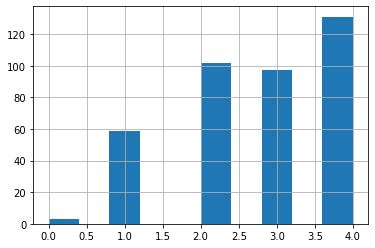

In [285]:
check_meduc = stud_math.copy()

function_type(check_meduc.mother_education)

Проверим образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

Есть пропуски

<AxesSubplot:>

6

2.0      True
3.0      True
4.0      True
1.0      True
0.0     False
40.0    False
Name: father_education, dtype: bool

count    371.000000
mean       2.614555
std        2.228732
min        0.000000
25%        2.000000
50%        2.000000
75%        3.000000
max       40.000000
Name: father_education, dtype: float64

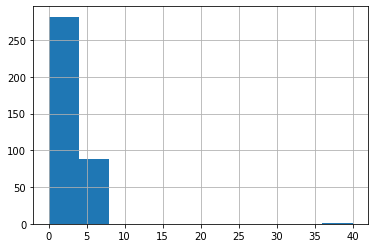

In [286]:
check_feduc = stud_math.copy()

function_type(check_feduc.father_education)

# отфильтровываем те значения, которые выходят за пределы условий столбца "образование отца"
check_feduc = check_feduc[(check_feduc.father_education <= 4) & (
    check_feduc.father_education >= 0)]

# добавляем измененые данные
stud_math.father_education = check_feduc.father_education

Проверим работу матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

В ходе корреляционного анализа столбцов mother_job и father_job, не выявлено зависимости между какими-либо столбцами.

In [326]:
check_mjob = stud_math.copy()

function_type(check_mjob.mother_job)

# преобразуем столбцы в числа и проведем корреляционный анализ
x = check_mjob[['mother_job', 'father_job']]
y = x.apply(LabelEncoder().fit_transform)
y.corr()

count       376
unique        5
top       other
freq        133
Name: mother_job, dtype: object

other       133
services     98
at_home      58
teacher      55
health       32
Name: mother_job, dtype: int64

,mother_job,father_job
mother_job,1.000000,0.051093
father_job,0.051093,1.000000


Проверим работу отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

In [327]:
check_fjob = stud_math.copy()

function_type(check_fjob.father_job)

count       359
unique        5
top       other
freq        197
Name: father_job, dtype: object

other       197
services    102
teacher      29
at_home      16
health       15
Name: father_job, dtype: int64

Проверим причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)

In [328]:
check_reason = stud_math.copy()

function_type(check_reason.school_reason)

count        378
unique         4
top       course
freq         137
Name: school_reason, dtype: object

course        137
home          104
reputation    103
other          34
Name: school_reason, dtype: int64

Проверим опекуна ('mother' - мать, 'father' - отец, 'other' - другое)

In [329]:
check_guardian = stud_math.copy()

function_type(check_guardian.guardian)

count        364
unique         3
top       mother
freq         250
Name: guardian, dtype: object

mother    250
father     86
other      28
Name: guardian, dtype: int64

Проверим время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)

<AxesSubplot:>

4

1.0     True
2.0     True
3.0     True
4.0    False
Name: travel_time, dtype: bool

count    367.000000
mean       1.438692
std        0.694181
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: travel_time, dtype: float64

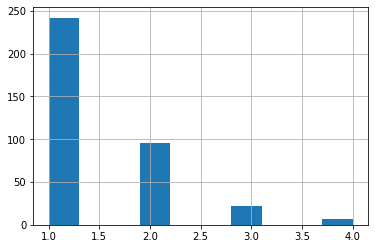

In [330]:
check_traveltime = stud_math.copy()

function_type(check_traveltime.travel_time)

Проверим время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)

<AxesSubplot:>

4

2.0    True
1.0    True
3.0    True
4.0    True
Name: study_time, dtype: bool

count    388.000000
mean       2.038660
std        0.842078
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: study_time, dtype: float64

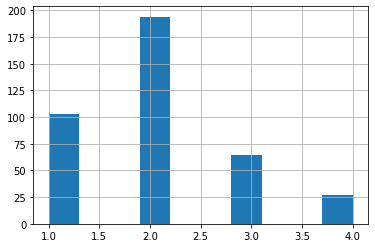

In [331]:
check_studytime = stud_math.copy()

function_type(check_studytime.study_time)

Проверим количество внеучебных неудач (n, если 1<=n<=3, иначе 0)

<AxesSubplot:>

4

0.0    True
1.0    True
2.0    True
3.0    True
Name: failures, dtype: bool

count    373.000000
mean       0.337802
std        0.743135
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: failures, dtype: float64

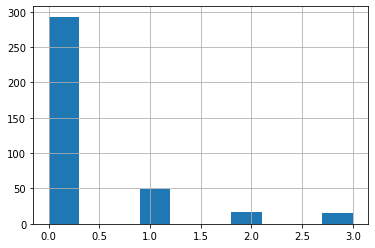

In [332]:
check_failures = stud_math.copy()

function_type(check_failures.failures)

Проверим дополнительная образовательная поддержка (yes или no)

В ходе корреляционного анализа все столбцов с ответами да-нет, не выявлено зависимости между какими-либо столбцами

count     386
unique      2
top        no
freq      335
Name: school_support, dtype: object

no     335
yes     51
Name: school_support, dtype: int64

Text(0.5, 1.0, 'Correlation Matrix')

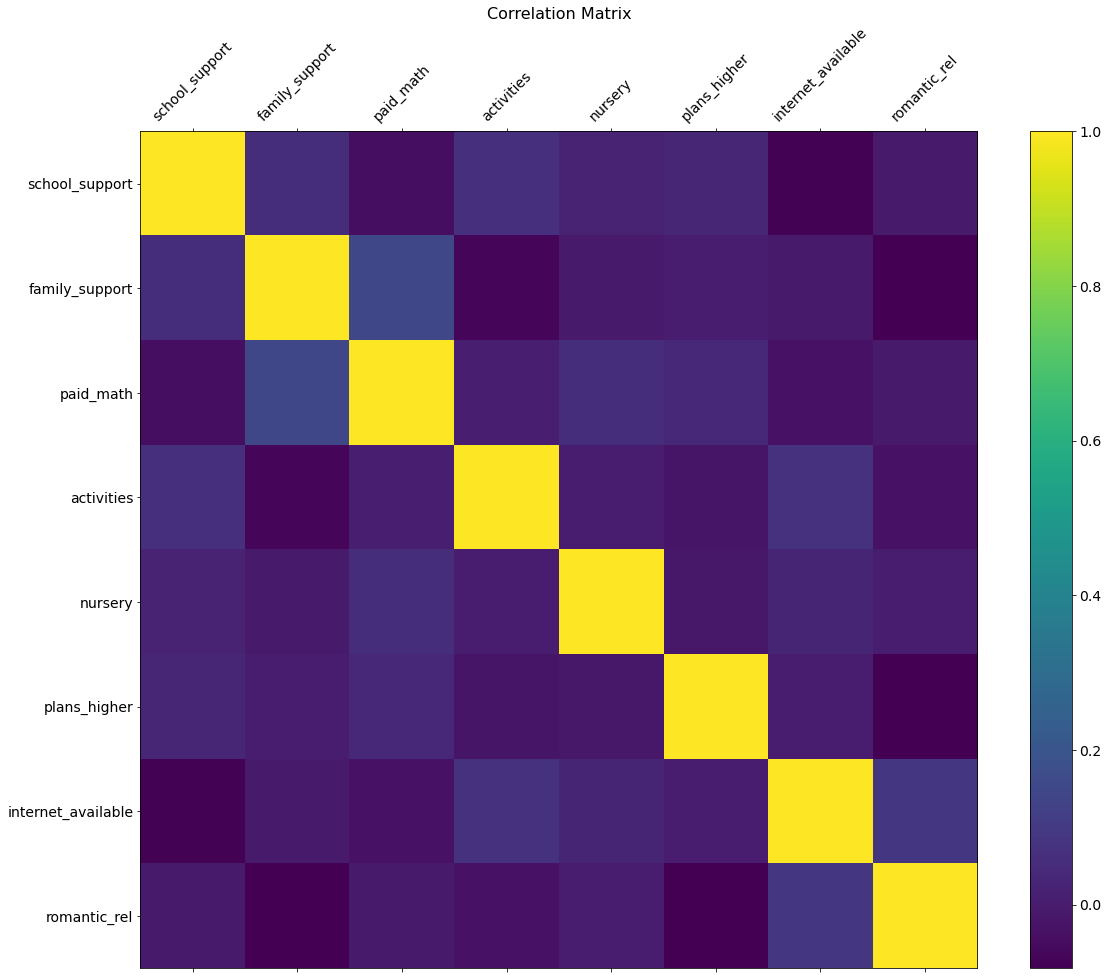

In [333]:
check_schoolsup = stud_math.copy()

function_type(check_schoolsup.school_support)

# преобразуем все столбцы с ответами да-нет в числа и проведем корреляционный анализ
x = check_schoolsup[['school_support', 'family_support', 'paid_math', 'activities',
                     'nursery', 'plans_higher', 'internet_available', 'romantic_rel']]
y = x.apply(LabelEncoder().fit_transform)

# построим корреляционную матрицу
f = plt.figure(figsize=(19, 15))
plt.matshow(y.corr(), fignum=f.number)
plt.xticks(range(y.shape[1]), y.columns, fontsize=14, rotation=45)
plt.yticks(range(y.shape[1]), y.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

# мы видим, что столбцы слабо скоррелированы

Проверим семейная образовательная поддержка (yes или no)

In [334]:
check_famsup = stud_math.copy()

display(function_type(check_famsup.family_support))
display(check_famsup.loc[:, ['family_support']].info())

count     356
unique      2
top       yes
freq      219
Name: family_support, dtype: object

yes    219
no     137
Name: family_support, dtype: int64

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   family_support  356 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

Проверим дополнительные платные занятия по математике (yes или no)

In [335]:
check_paid = stud_math.copy()

function_type(check_paid.paid_math)
display(check_paid.loc[:, ['paid_math']].info())

count     355
unique      2
top        no
freq      200
Name: paid_math, dtype: object

no     200
yes    155
Name: paid_math, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   paid_math  355 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

Проверим дополнительные внеучебные занятия (yes или no)

In [336]:
check_activities = stud_math.copy()

function_type(check_activities.activities)
display(check_activities.loc[:, ['activities']].info())

count     381
unique      2
top       yes
freq      195
Name: activities, dtype: object

yes    195
no     186
Name: activities, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   activities  381 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

Проверим, посещал ли ученик детский сад (yes или no)

In [337]:
check_nursery = stud_math.copy()

function_type(check_nursery.nursery)
display(check_nursery.loc[:, ['nursery']].info())

count     379
unique      2
top       yes
freq      300
Name: nursery, dtype: object

yes    300
no      79
Name: nursery, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   nursery  379 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

Время на учёбу помимо школы в неделю

При корреляционном анализе я выяснил, что данная колонка полностью коррелируется с колонкой 'study_time', поэтому можем удалить этот столбец

In [338]:
check_studytime2 = stud_math.copy()

stud_math = check_studytime2.drop(['study_time,granular'], axis=1)

Проверим, кто хочет получить высшее образование (yes или no)

In [339]:
check_higher = stud_math.copy()

function_type(check_higher.plans_higher)
display(check_higher.loc[:, ['plans_higher']].info())

count     375
unique      2
top       yes
freq      356
Name: plans_higher, dtype: object

yes    356
no      19
Name: plans_higher, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   plans_higher  375 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

Проверим наличие интернета дома (yes или no)

In [340]:
check_internet = stud_math.copy()

function_type(check_internet.internet_available)
display(check_internet.loc[:, ['internet_available']].info())

count     361
unique      2
top       yes
freq      305
Name: internet_available, dtype: object

yes    305
no      56
Name: internet_available, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   internet_available  361 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

Проверим учеников в романтических отношениях (yes или no)

In [341]:
check_romantic = stud_math.copy()

function_type(check_romantic.romantic_rel)
display(check_romantic.loc[:, ['romantic_rel']].info())

count     364
unique      2
top        no
freq      240
Name: romantic_rel, dtype: object

no     240
yes    124
Name: romantic_rel, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   romantic_rel  364 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

Проверим cемейные отношения (от 1 - очень плохо до 5 - очень хорошо)

Видно, что есть данные, которые не соотвествуют условиям данного столбца, значит уберем значения, которые не удовлетворяют условиям данной колонки

<AxesSubplot:>

5

4.0     True
5.0     True
3.0     True
2.0     True
1.0    False
Name: family_rel, dtype: bool

count    367.000000
mean       3.950954
std        0.891853
min        1.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: family_rel, dtype: float64

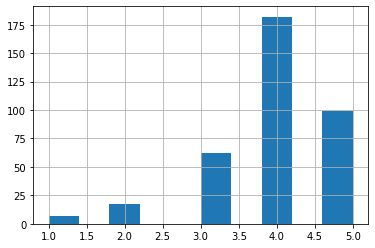

In [343]:
check_famrel = stud_math.copy()

function_type(check_famrel.family_rel)

# добавим откорректированную информацию в основную базу данных
stud_math.family_rel = check_famrel.family_rel[(
    1 <= check_famrel.family_rel) & (check_famrel.family_rel <= 5)]

Свободное время после школы (от 1 - очень мало до 5 - очень много)

<AxesSubplot:>

5

3.0    True
4.0    True
2.0    True
5.0    True
1.0    True
Name: free_time, dtype: bool

count    384.000000
mean       3.231771
std        0.993940
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: free_time, dtype: float64

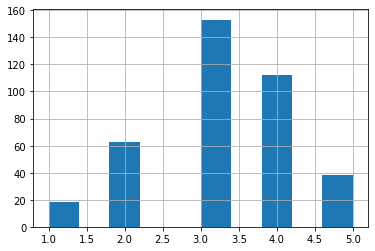

In [344]:
check_freetime = stud_math.copy()

function_type(check_freetime.free_time)

Проведение времени с друзьями (от 1 - очень мало до 5 - очень много)

<AxesSubplot:>

5

3.0    True
2.0    True
4.0    True
5.0    True
1.0    True
Name: friend_time, dtype: bool

count    387.000000
mean       3.105943
std        1.115896
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: friend_time, dtype: float64

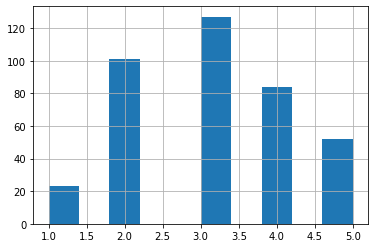

In [345]:
check_goout = stud_math.copy()

function_type(check_goout.friend_time)

Текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)

<AxesSubplot:>

5

5.0    True
3.0    True
4.0    True
1.0    True
2.0    True
Name: health, dtype: bool

count    380.000000
mean       3.531579
std        1.396019
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: health, dtype: float64

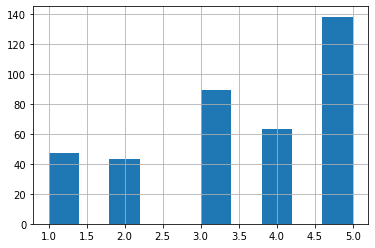

In [346]:
check_health = stud_math.copy()

function_type(check_health.health)

Количество пропущенных занятий

Мы видим, что в данной колонке есть существенные выбросы, но при этом данный критерий может повлиять на оценку, поэтому оставим все значения для построения модели

25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-12.0, 20.0].


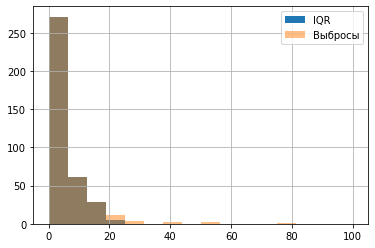

In [347]:
check_absences = stud_math.copy()

IQR = check_absences.absences.quantile(
    0.75) - check_absences.absences.quantile(0.25)
perc25 = check_absences.absences.quantile(0.25)
perc75 = check_absences.absences.quantile(0.75)

print(
    '25-й перцентиль: {},'.format(perc25),
    '75-й перцентиль: {},'.format(perc75),
    "IQR: {}, ".format(IQR),
    "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

check_absences.absences.loc[check_absences.absences.between(
    perc25 - 1.5*IQR,
    perc75 + 1.5*IQR)].hist(bins=16, range=(0, 100), label='IQR')

check_absences.absences.loc[check_absences.absences <= 100].hist(
    alpha=0.5, bins=16, range=(0, 100), label='Выбросы')

plt.legend()

Проверим колонку с оценками по экзамену по математике

Есть пропуски в столбце, поэтому уберем их, потому что мы не сможем предугадать оценку с помощью таких строк

25-й перцентиль: 40.0, 75-й перцентиль: 70.0, IQR: 30.0,  Границы выбросов: [-5.0, 115.0].


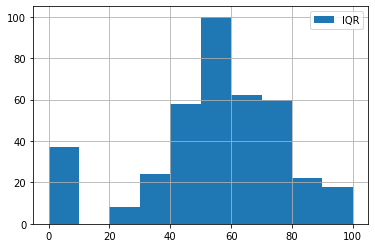

In [348]:
check_score = stud_math.copy()

IQR = check_score.math_score.quantile(
    0.75) - check_score.math_score.quantile(0.25)
perc25 = check_score.math_score.quantile(0.25)
perc75 = check_score.math_score.quantile(0.75)

print('25-й перцентиль: {},'.format(perc25),
      '75-й перцентиль: {},'.format(perc75),
      "IQR: {}, ".format(IQR),
      "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

check_score.math_score.loc[check_score.math_score.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(
    bins=10, range=(0, 100), label='IQR')

plt.legend()

In [349]:
# уберем пропуски в колонке 'math_score' и выбросы
stud_math = check_score[check_score.math_score.between(
    perc25 - 1.5*IQR, perc75 + 1.5*IQR)]
stud_math.math_score.dropna()

stud_math.math_score.value_counts()

50.0     54
55.0     46
0.0      37
75.0     33
65.0     31
60.0     31
40.0     31
45.0     27
70.0     27
80.0     16
30.0     15
90.0     12
35.0      9
25.0      7
85.0      6
95.0      5
20.0      1
100.0     1
Name: math_score, dtype: int64

Уберем пропуски в остальной базе данных

In [350]:
def fill_blanks(column):
    if stud_math.loc[:, column].dtype == 'int64' or stud_math.loc[:, column].dtype == 'int64':
        stud_math.loc[:, column] = stud_math.loc[:, column].fillna(
            stud_math.loc[:, column].mode())
    else:
        a = stud_math.loc[:, column].value_counts()
        stud_math.loc[:, column] = stud_math.loc[:,
                                                 column].fillna(a.index[0])
    return stud_math.loc[:, column]


for column in stud_math.columns:
    fill_blanks(column)

stud_math = stud_math.set_axis(['school', 'sex', 'age', 'address_type', 'family_size',
                                'parents_status', 'mother_education', 'father_education',
                                'mother_job', 'father_job', 'school_reason', 'guardian',
                                'travel_time', 'study_time', 'failures', 'school_support',
                                'family_support', 'paid_math', 'activities', 'nursery',
                                'plans_higher', 'internet_available',
                                'romantic_rel', 'family_rel', 'free_time', 'friend_time',
                                'health', 'absences', 'math_score', 'blanks'], axis=1)

C:\Users\79253\Documents\Data scientist\Anaconda\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Проведем корреляционный анализ числовых значений

Все 11 колонок слабоскоррелированны с оценкой за экзамен

,age,mother_education,father_education,travel_time,study_time,failures,family_rel,free_time,friend_time,health,absences,math_score,blanks
age,1.000000,-0.145755,-0.126522,0.076013,-0.018019,0.206279,0.053021,0.013994,0.121057,-0.061752,0.095166,-0.155726,-0.036195
mother_education,-0.145755,1.000000,0.254268,-0.156090,0.076035,-0.238295,-0.009469,0.040743,0.070310,-0.070420,-0.012331,0.200890,-0.003887
father_education,-0.126522,0.254268,1.000000,0.048258,0.054663,-0.145649,0.042224,-0.063931,-0.019476,0.004875,0.003154,0.075273,-0.051819
travel_time,0.076013,-0.156090,0.048258,1.000000,-0.098226,0.035113,-0.034992,-0.016696,0.046390,-0.035336,-0.037054,-0.056535,-0.053626
study_time,-0.018019,0.076035,0.054663,-0.098226,1.000000,-0.169399,0.027460,-0.122057,-0.053554,-0.063876,-0.024045,0.114295,-0.088563
failures,0.206279,-0.238295,-0.145649,0.035113,-0.169399,1.000000,-0.007672,0.087558,0.101036,0.079030,0.056706,-0.337187,0.039992
family_rel,0.053021,-0.009469,0.042224,-0.034992,0.027460,-0.007672,1.000000,0.156171,0.061699,0.103669,-0.077094,0.048896,0.065070
free_time,0.013994,0.040743,-0.063931,-0.016696,-0.122057,0.087558,0.156171,1.000000,0.294450,0.067629,0.007472,0.017481,0.043116
friend_time,0.121057,0.070310,-0.019476,0.046390,-0.053554,0.101036,0.061699,0.294450,1.000000,-0.015108,-0.050589,-0.127742,0.007922
health,-0.061752,-0.070420,0.004875,-0.035336,-0.063876,0.079030,0.103669,0.067629,-0.015108,1.000000,-0.019598,-0.080583,0.104500


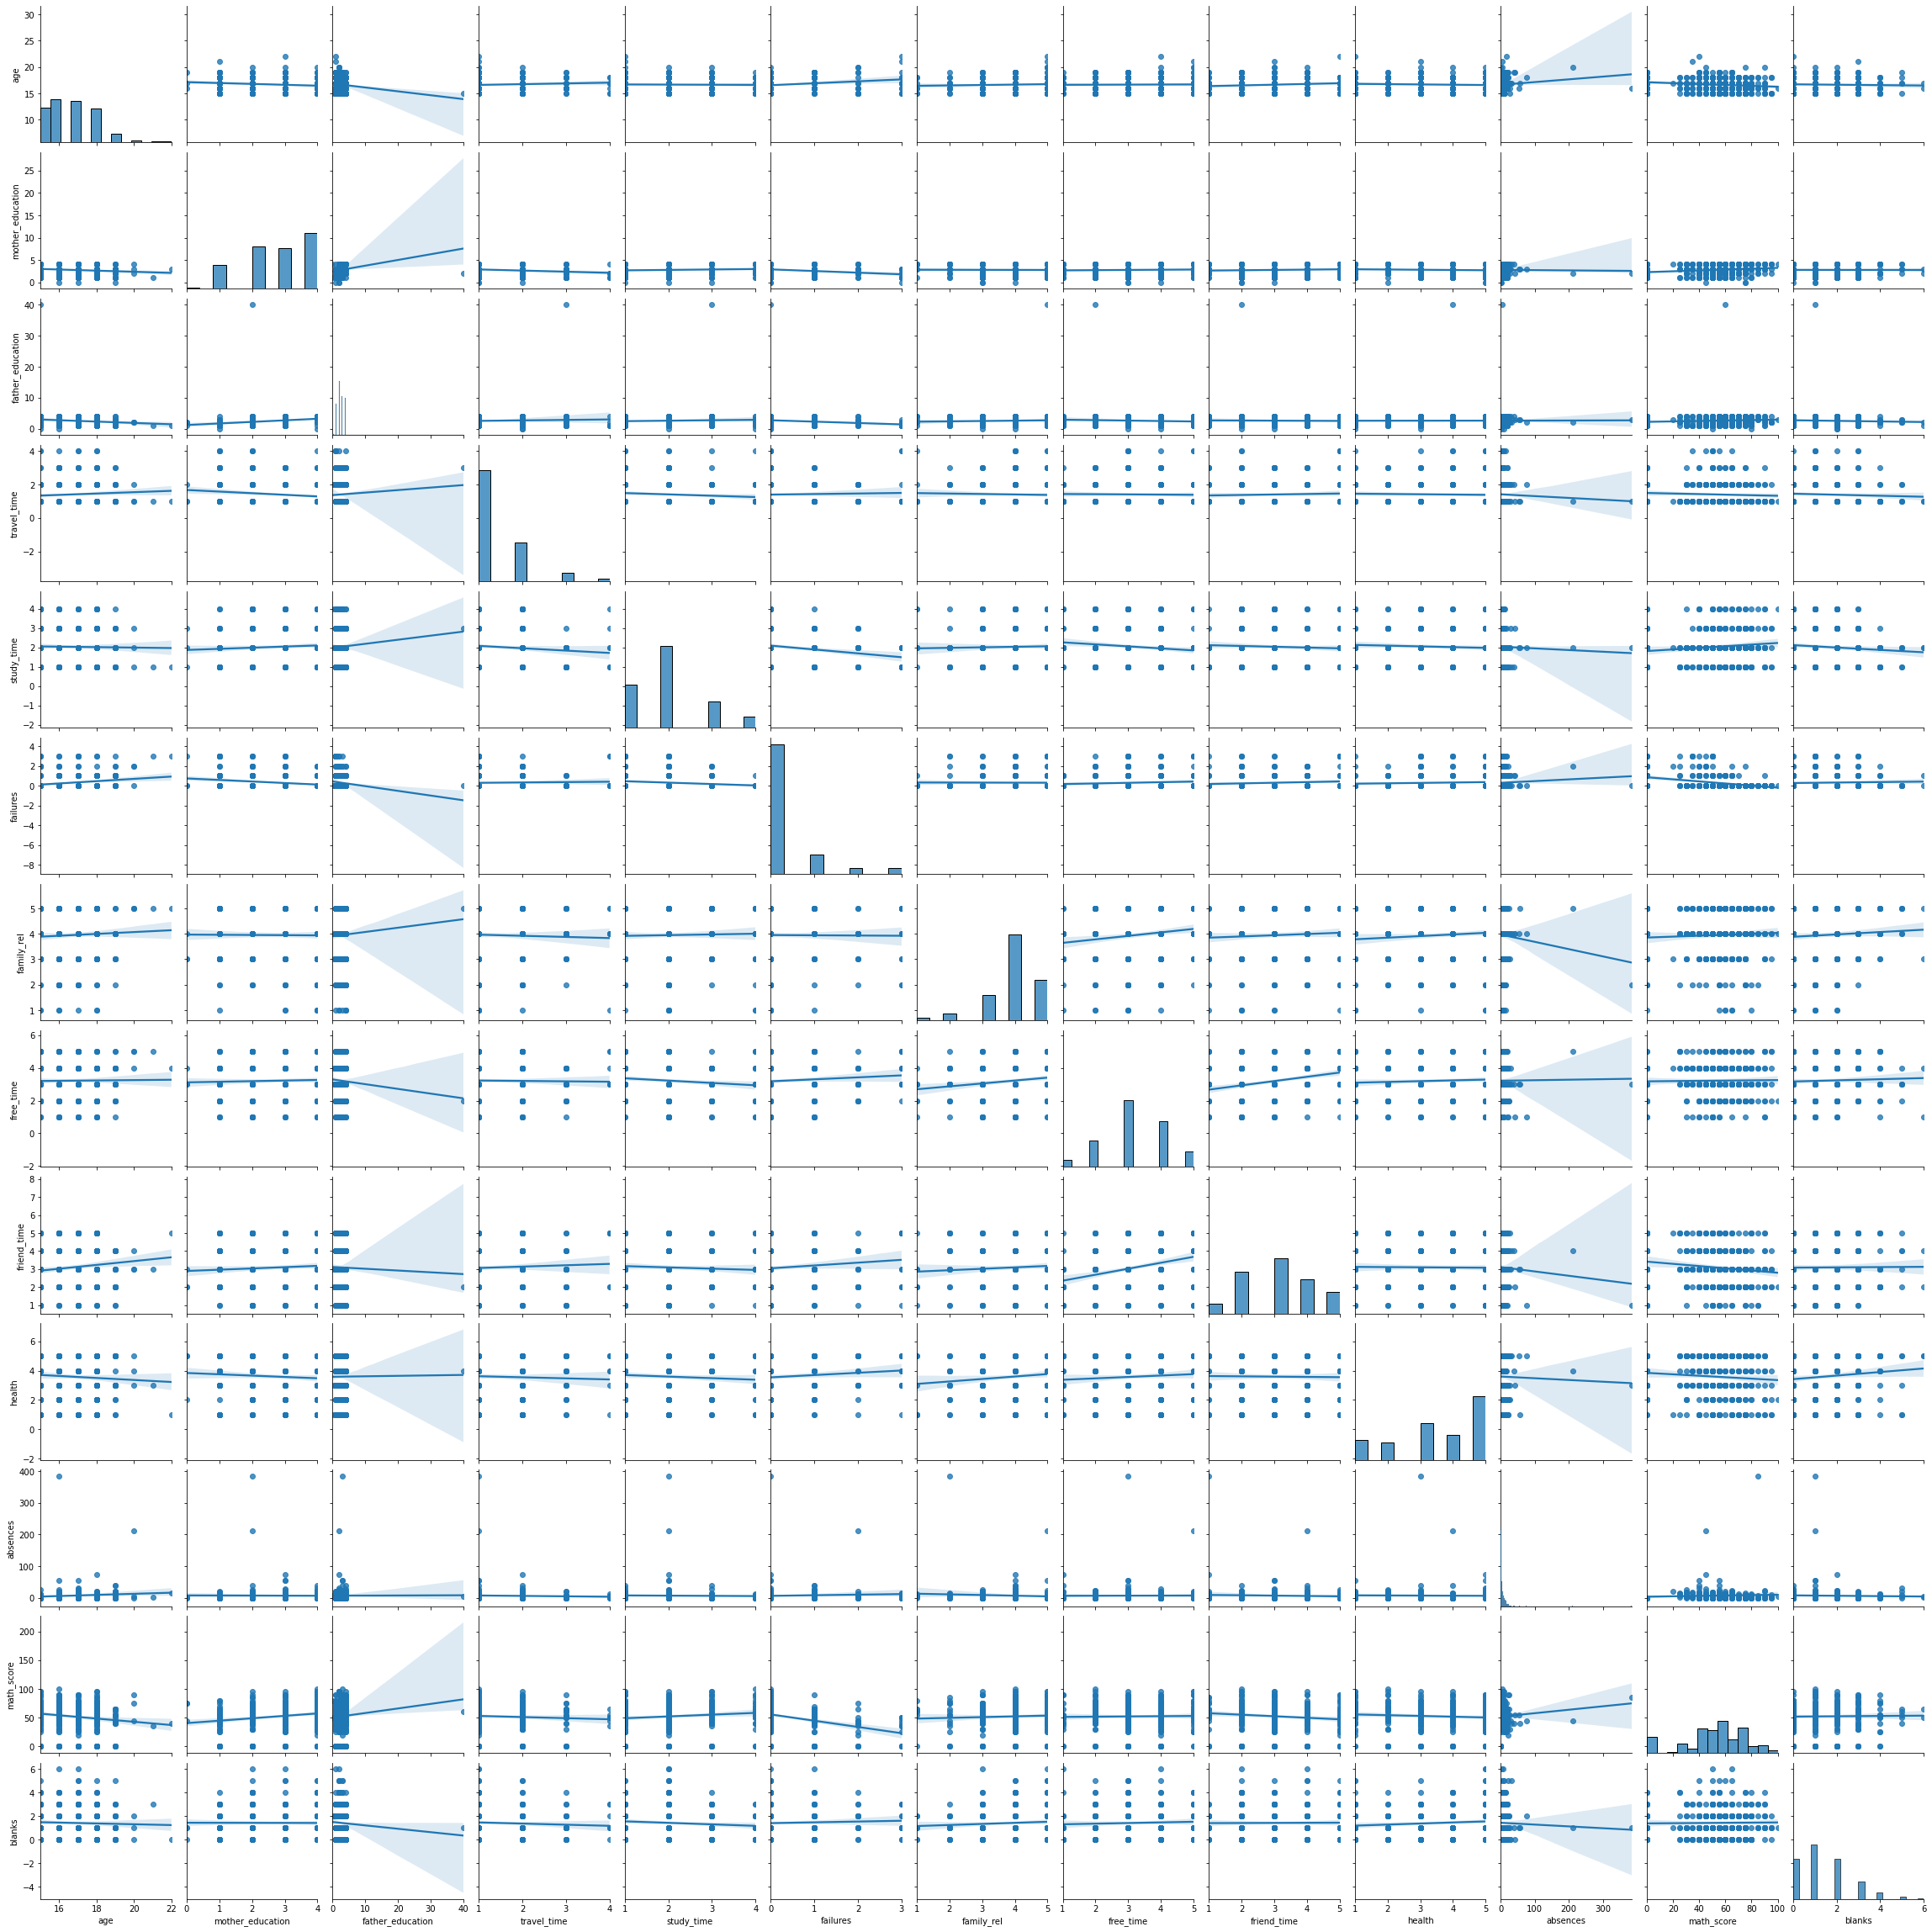

In [351]:
sns.pairplot(stud_math, kind='reg')
stud_math.corr()

Построим бокс-плоты для столбцов с номинативными значениями

Посмотрим по графикам, какие факторы влияют на оценку по математике

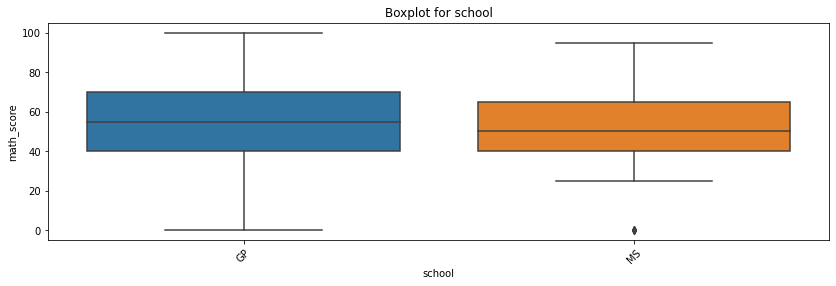

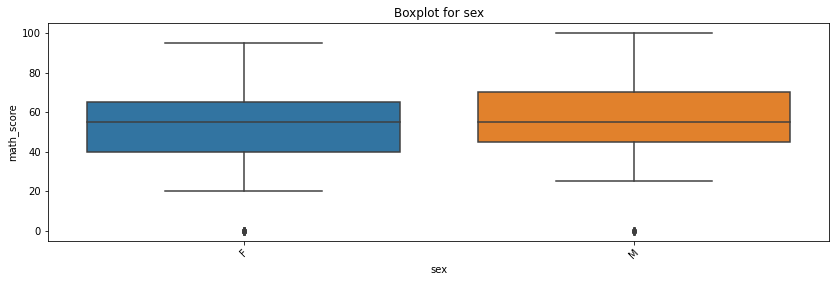

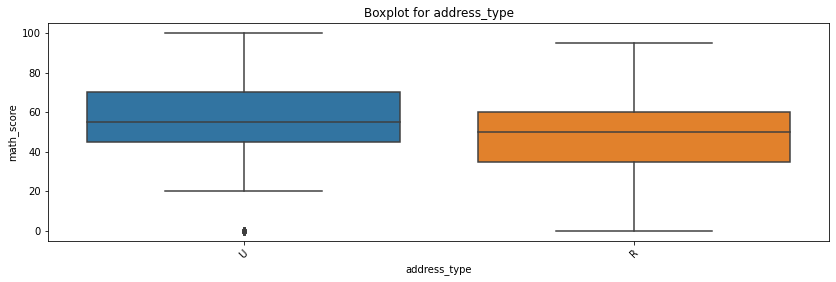

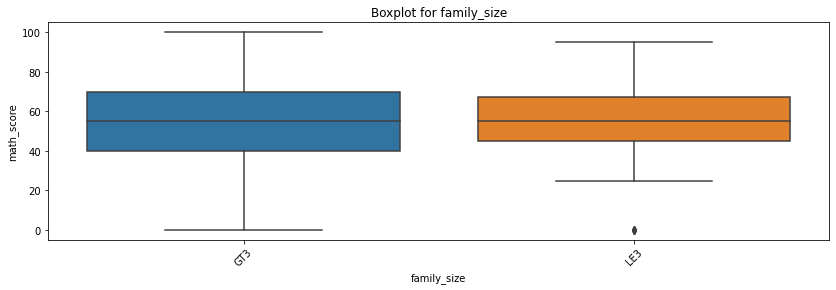

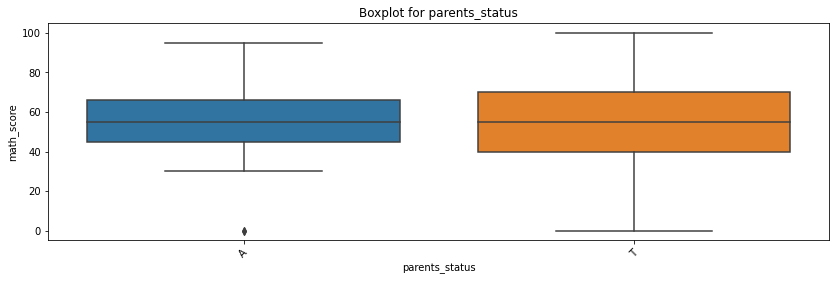

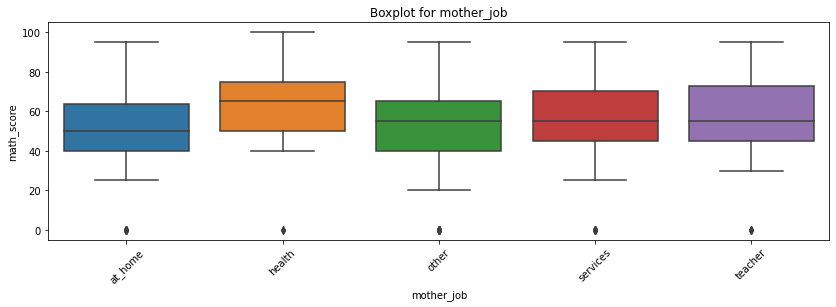

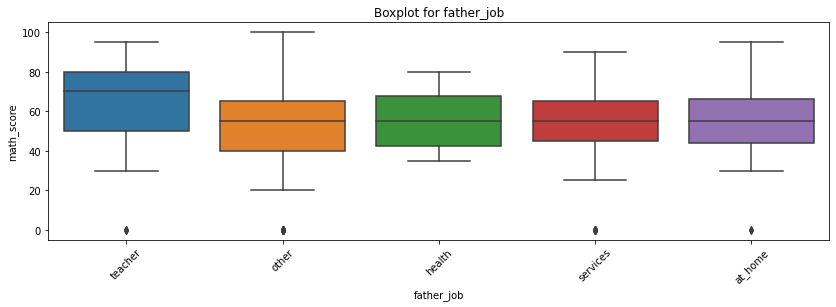

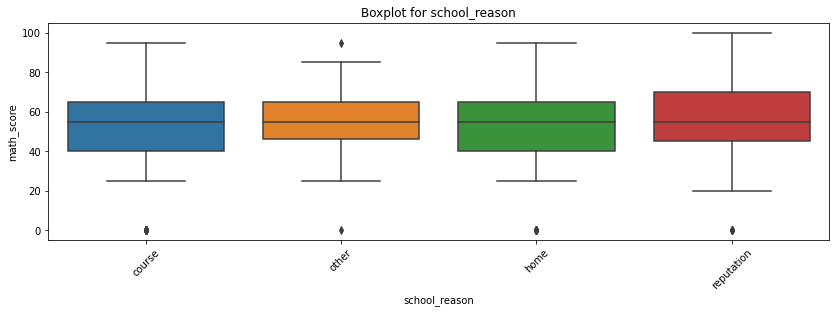

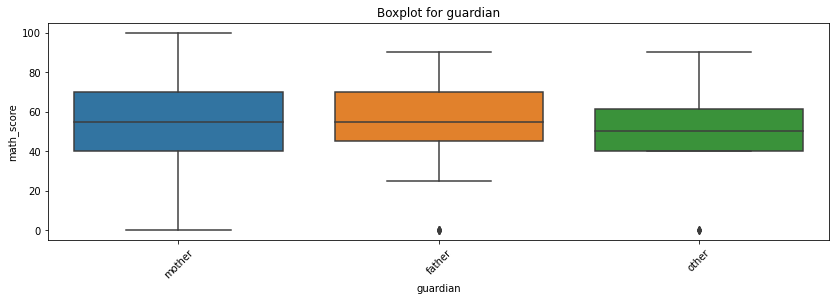

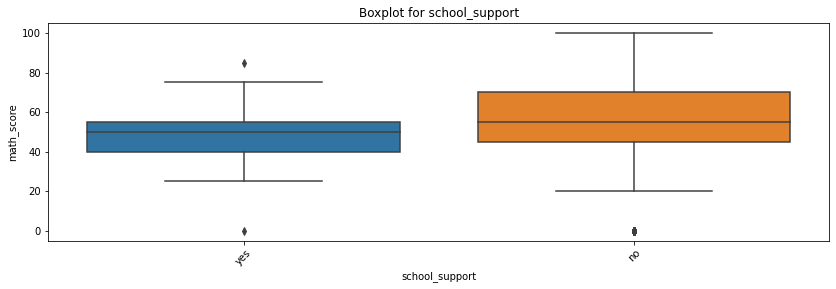

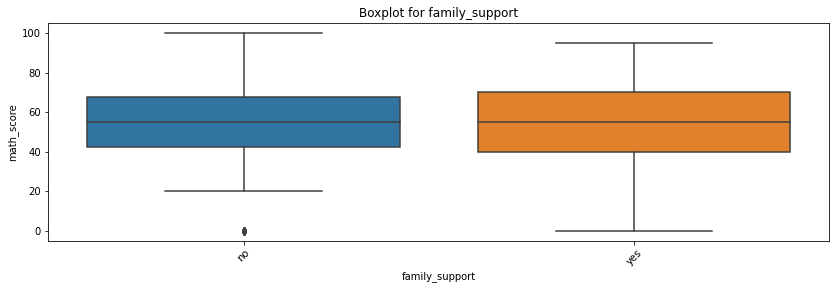

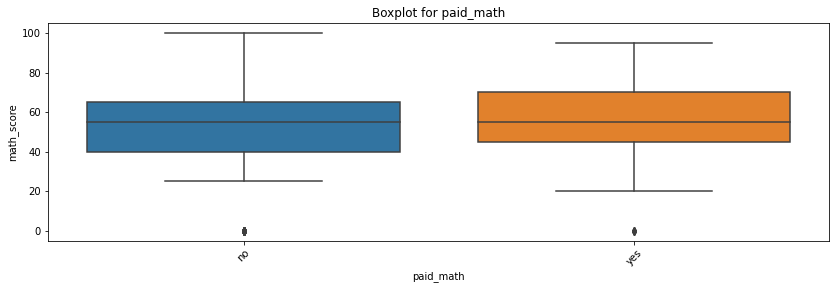

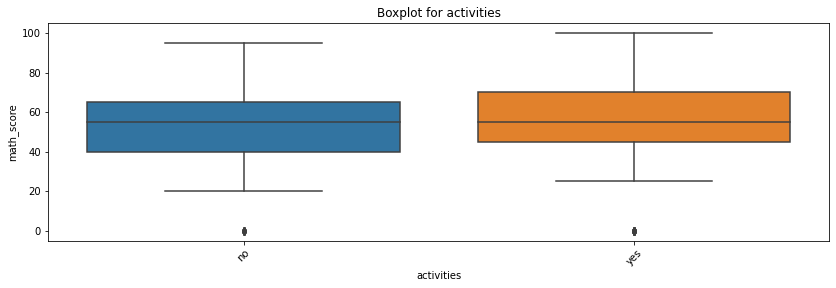

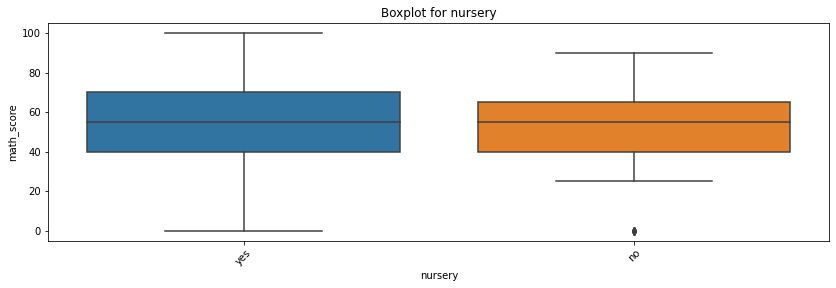

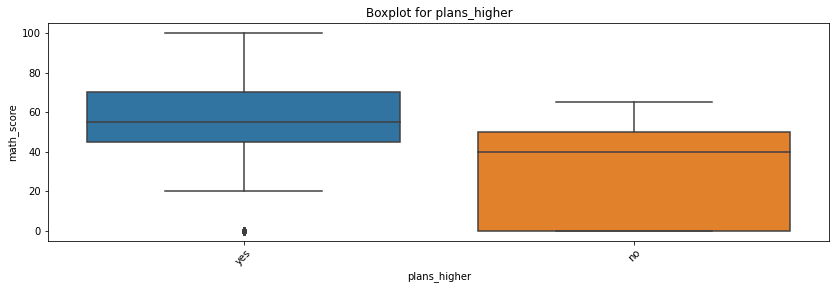

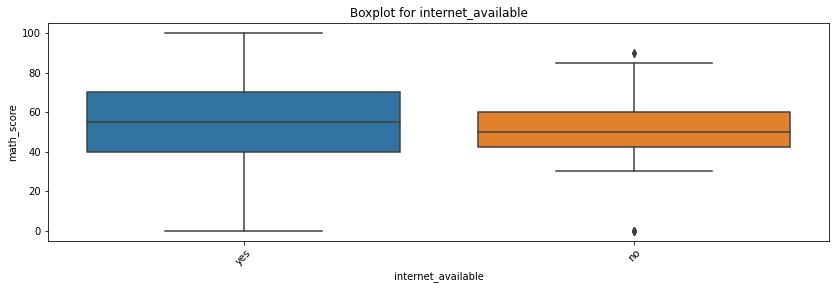

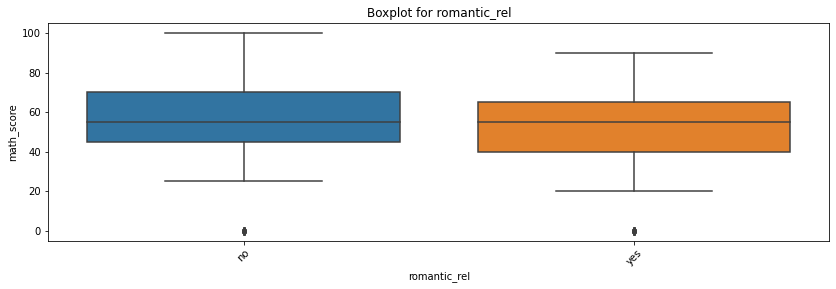

In [352]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='math_score',
                data=stud_math.loc[stud_math.loc[:, column].isin(
                    stud_math.loc[:, column].value_counts().index[:20])],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()


for col in ['school', 'sex', 'address_type', 'family_size', 'parents_status', 'mother_job',
            'father_job', 'school_reason', 'guardian', 'school_support', 'family_support',
            'paid_math', 'activities', 'nursery',
            'plans_higher', 'internet_available', 'romantic_rel']:
    get_boxplot(col)

Найдем колонки со статистически значимыми различиями

Проверим, есть ли статистическая разница в распределении оценок по номинативным признакам, с помощью теста Стьюдента. Проверим нулевую гипотезу о том, что распределения оценок за экзамен по различным параметрам неразличимы.
Как мы видим, серьёзно отличаются два параметра: plan_higher и  romantic_rel. Оставим эти переменные в датасете для дальнейшего построения модели.

In [353]:
def get_stat_dif(column):
    cols = stud_math.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(stud_math.loc[stud_math.loc[:, column] == comb[0], 'math_score'],
                     stud_math.loc[stud_math.loc[:, column] == comb[1], 'math_score']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break


for col in ['school', 'sex', 'address_type', 'family_size', 'parents_status', 'mother_job',
            'father_job', 'school_reason', 'guardian', 'school_support', 'family_support', 'paid_math', 'activities', 'nursery',
            'plans_higher', 'internet_available', 'romantic_rel']:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки address_type
Найдены статистически значимые различия для колонки mother_job
Найдены статистически значимые различия для колонки plans_higher
Найдены статистически значимые различия для колонки romantic_rel


Создадим базу данных для построения модели

In [314]:
for_model = stud_math.loc[:, ['address_type', 'mother_job', 'age', 'mother_education', 'father_education',
                              'travel_time', 'study_time', 'failures', 'family_rel',
                              'free_time', 'friend_time', 'health', 'absences', 'plans_higher',
                              'romantic_rel']]
for_model.info()
display(for_model)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   address_type      389 non-null    object 
 1   mother_job        389 non-null    object 
 2   age               389 non-null    int64  
 3   mother_education  389 non-null    float64
 4   father_education  389 non-null    float64
 5   travel_time       389 non-null    float64
 6   study_time        389 non-null    float64
 7   failures          389 non-null    float64
 8   family_rel        389 non-null    float64
 9   free_time         389 non-null    float64
 10  friend_time       389 non-null    float64
 11  health            389 non-null    float64
 12  absences          389 non-null    float64
 13  plans_higher      389 non-null    object 
 14  romantic_rel      389 non-null    object 
dtypes: float64(10), int64(1), object(4)
memory usage: 48.6+ KB


,address_type,mother_job,age,mother_education,father_education,travel_time,study_time,failures,family_rel,free_time,friend_time,health,absences,plans_higher,romantic_rel
0,U,at_home,18,4.0,4.0,2.0,2.0,0.0,4.0,3.0,4.0,3.0,6.0,yes,no
1,U,at_home,17,1.0,1.0,1.0,2.0,0.0,5.0,3.0,3.0,3.0,4.0,yes,no
2,U,at_home,15,1.0,1.0,1.0,2.0,3.0,4.0,3.0,2.0,3.0,10.0,yes,no
3,U,health,15,4.0,2.0,1.0,3.0,0.0,3.0,2.0,2.0,5.0,2.0,yes,yes
4,U,other,16,3.0,3.0,1.0,2.0,0.0,4.0,3.0,2.0,5.0,4.0,yes,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,U,services,20,2.0,2.0,1.0,2.0,2.0,5.0,5.0,4.0,4.0,212.0,yes,no
391,U,services,17,3.0,1.0,2.0,1.0,0.0,2.0,4.0,5.0,2.0,3.0,yes,no
392,R,other,21,1.0,1.0,1.0,1.0,3.0,5.0,5.0,3.0,3.0,3.0,yes,no
393,R,services,18,3.0,2.0,3.0,1.0,0.0,4.0,4.0,1.0,5.0,0.0,yes,no
